In [2]:
!nvidia-smi

Tue Feb 15 16:06:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!cp "/content/drive/MyDrive/videos.zip" "/content/"

In [ ]:
!unzip *.zip && rm -rf *.zip

In [ ]:
!pip install keras-video-generators

#Splitting Dataset

In [34]:
import shutil
import os
import numpy as np
import argparse

def get_files_from_folder(path):

    files = os.listdir(path)
    return np.asarray(files)

def main(path_to_data, path_to_test_data, train_ratio):
    # get dirs
    _, dirs, _ = next(os.walk(path_to_data))

    # calculates how many train data per class
    data_counter_per_class = np.zeros((len(dirs)))
    for i in range(len(dirs)):
        path = os.path.join(path_to_data, dirs[i])
        files = get_files_from_folder(path)
        data_counter_per_class[i] = len(files)
    test_counter = np.round(data_counter_per_class * (1 - train_ratio))

    # transfers files
    for i in range(len(dirs)):
        path_to_original = os.path.join(path_to_data, dirs[i])
        path_to_save = os.path.join(path_to_test_data, dirs[i])

        #creates dir
        if not os.path.exists(path_to_save):
            os.makedirs(path_to_save)
        files = get_files_from_folder(path_to_original)
        # moves data
        for j in range(int(test_counter[i])):
            dst = os.path.join(path_to_save, files[j])
            src = os.path.join(path_to_original, files[j])
            shutil.move(src, dst)


if __name__ == "__main__":
  main("/content/videos/train", "/content/videos/test", float(0.8))

#VideoDataGenerator

In this simple video data generator we simply collect or get N number of distributed images from video at different timestamps or different times.

In [15]:
import os
import glob
from tensorflow import keras
from videogenerator import VideoFrameGenerator

In [37]:
%cd "/content/videos"

/content/videos


In [38]:
# use sub directories names as classes
classes = [i.split(os.path.sep)[1] for i in glob.glob('train/*')]
classes.sort()

In [39]:
classes

['clap', 'dive', 'golf', 'kiss', 'walk']

In [40]:
# some global params
SIZE = (128, 128)
CHANNELS = 3
NUMBER_OF_FRAMES = 7
BATCH_SIZE = 8

In [41]:
# pattern to get videos and classes
train_glob_pattern='train/{classname}/*.avi'
test_glob_pattern='test/{classname}/*.avi'

In [42]:
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)

train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=train_glob_pattern,
    nb_frames=NUMBER_OF_FRAMES, 
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=False)

valid = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=test_glob_pattern,
    nb_frames=NUMBER_OF_FRAMES, 
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    use_frame_cache=False)

Total data: 5 classes for 810 files for train
Total data: 5 classes for 202 files for train


In [43]:
from videodatagenutils import show_sample

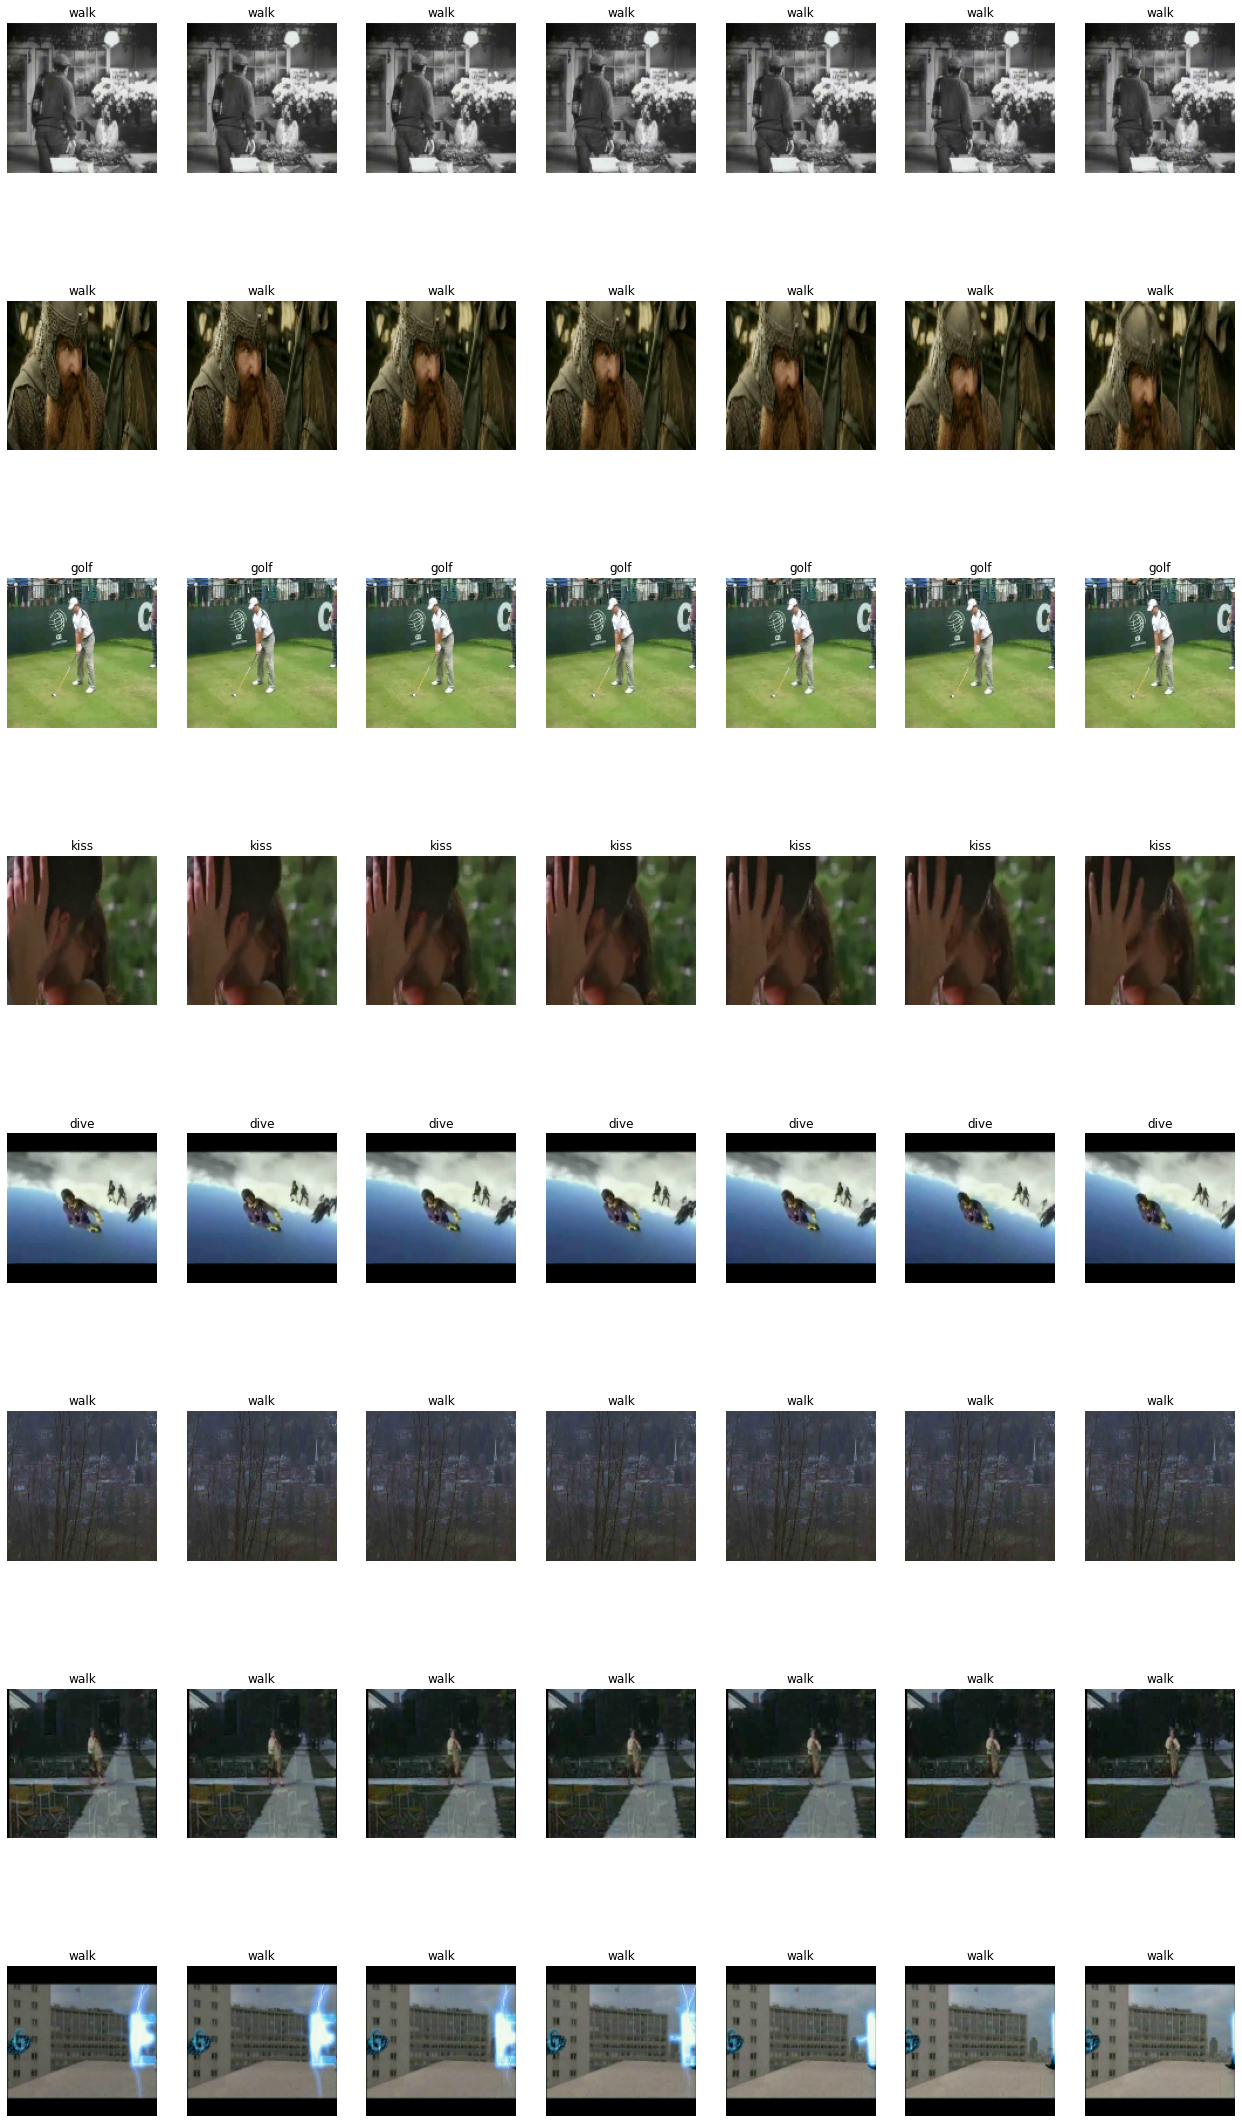

In [46]:
show_sample(valid)

#CNN

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import MaxPooling2D

In [54]:
momentum = 0.8

conv_model = Sequential()

conv_model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", input_shape=(128, 128, 3)))
conv_model.add(Activation("relu"))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_model.add(BatchNormalization(momentum=momentum))

conv_model.add(Dropout(rate=0.2))
conv_model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same"))
conv_model.add(Activation("relu"))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_model.add(BatchNormalization(momentum=momentum))

conv_model.add(Dropout(rate=0.2))
conv_model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same"))
conv_model.add(Activation("relu"))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_model.add(BatchNormalization(momentum=momentum))

conv_model.add(Dropout(rate=0.2))
conv_model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same"))
conv_model.add(Activation("relu"))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_model.add(BatchNormalization(momentum=momentum))

conv_model.add(GlobalMaxPooling2D())

In [55]:
conv_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 activation_8 (Activation)   (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)       

In [57]:
num_classes = len(classes)

In [58]:
num_classes

5

#LSTM

In [61]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import TimeDistributed

In [63]:
inp_td = (NUMBER_OF_FRAMES, 128, 128, 3)

lstm_model = Sequential()

lstm_model.add(TimeDistributed(conv_model, input_shape=inp_td))

lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dropout(rate=0.15))

lstm_model.add(Dense(units=1024))
lstm_model.add(Activation("relu"))
lstm_model.add(Dropout(rate=0.5))

lstm_model.add(Dense(units=512))
lstm_model.add(Activation("relu"))
lstm_model.add(Dropout(rate=0.5))

lstm_model.add(Dense(units=256))
lstm_model.add(Activation("relu"))
lstm_model.add(Dropout(rate=0.5))

lstm_model.add(Dense(num_classes))
lstm_model.add(Activation("softmax"))

In [64]:
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 7, 128)           242240    
 tributed)                                                       
                                                                 
 bidirectional_2 (Bidirectio  (None, 7, 128)           98816     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1024)              132096    
                                                      

In [65]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.001)
lstm_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [67]:
!pwd

/content/videos


In [68]:
!ls

chkp  test  train


In [69]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

EPOCHS=50
# create a "chkp" directory before to run that
# because ModelCheckpoint will write models inside
callbacks = [
    ReduceLROnPlateau(verbose=1),
    ModelCheckpoint(
        'chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
]

#Training

In [70]:
history = lstm_model.fit(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/50
101/101 [==============================] - ETA: 0s - loss: 1.3200 - accuracy: 0.5272
Epoch 00001: saving model to chkp/weights.01-1.26.hdf5
101/101 [==============================] - 66s 370ms/step - loss: 1.3200 - accuracy: 0.5272 - val_loss: 1.2619 - val_accuracy: 0.5400 - lr: 0.0010
Epoch 2/50
101/101 [==============================] - ETA: 0s - loss: 1.2081 - accuracy: 0.5470
Epoch 00002: saving model to chkp/weights.02-1.13.hdf5
101/101 [==============================] - 35s 351ms/step - loss: 1.2081 - accuracy: 0.5470 - val_loss: 1.1344 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 3/50
101/101 [==============================] - ETA: 0s - loss: 1.1411 - accuracy: 0.5644
Epoch 00003: saving model to chkp/weights.03-1.09.hdf5
101/101 [==============================] - 38s 374ms/step - loss: 1.1411 - accuracy: 0.5644 - val_loss: 1.0862 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/50
101/101 [==============================] - ETA: 0s - loss: 1.1614 - accuracy: 0.5644
Epoch 0000

In [71]:
import matplotlib.pyplot as plt

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

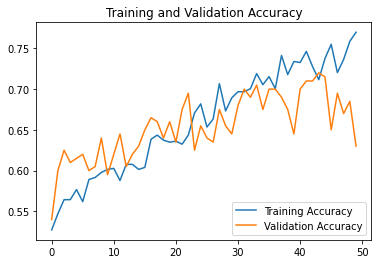

In [73]:
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

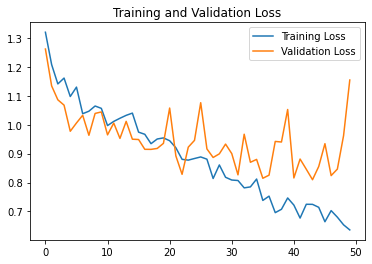

In [74]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [77]:
!cp "/content/videos/chkp/weights.44-0.81.hdf5" "/content/drive/MyDrive"

#SlidingDataGenerator

In this data generator we are basically getting frames from a specific time frame for example if we set 2 seconds then the N number of frames are collected from 2-2 seconds of time stamps.

In [76]:
from slidingvideogenerator import SlidingFrameGenerator

In [94]:
BATCH_SIZE = 32
NUMBER_OF_FRAMES = 7

In [95]:
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)

train = SlidingFrameGenerator(
    classes=classes, 
    glob_pattern=train_glob_pattern,
    nb_frames=NUMBER_OF_FRAMES, 
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    sequence_time=2, #2 Seconds
    use_frame_cache=False)

valid = SlidingFrameGenerator(
    classes=classes, 
    glob_pattern=test_glob_pattern,
    nb_frames=NUMBER_OF_FRAMES, 
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    sequence_time=2,
    use_frame_cache=False)

Total data: 5 classes for 810 files for train
Checking files to find possible sequences, please wait...
For 810 files, I found 38017 possible sequence samples
Total data: 5 classes for 202 files for train
Checking files to find possible sequences, please wait...
For 202 files, I found 8609 possible sequence samples


In [79]:
classes

['clap', 'dive', 'golf', 'kiss', 'walk']

In [80]:
!ls

chkp  test  train


In [92]:
!rm -rf chkp/
!mkdir chkp/

In [82]:
!ls

chkp  test  train


In [96]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.001)
lstm_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [97]:
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 7, 128)           242240    
 tributed)                                                       
                                                                 
 bidirectional_2 (Bidirectio  (None, 7, 128)           98816     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1024)              132096    
                                                      

In [98]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

EPOCHS=50
# create a "chkp" directory before to run that
# because ModelCheckpoint will write models inside
callbacks = [
    ReduceLROnPlateau(verbose=1),
    ModelCheckpoint(
        'chkp/s.weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
]

In [ ]:
history = lstm_model.fit(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)

#Testing

In [2]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

model = load_model("/content/drive/MyDrive/weights.44-0.81.hdf5")

In [3]:
NBFRAMES = []

In [31]:
img_height , img_width = 128, 128
nb_frames = 7


def frames_extraction(video_path):
    frames_list = []
     
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable 
    count = 1
 
    while count <= nb_frames: 
         
        success, image = vidObj.read() 
        if success:
            image = cv2.resize(image, (img_height, img_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break
    
    frames_list = np.asarray(frames_list)
    
    return frames_list

In [35]:
frames = frames_extraction("/content/videos/test/dive/Fellowship_7_dive_f_cm_np1_ba_bad_0.avi")
frames = frames.reshape(-1, 7, 128, 128, 3)
frames.shape
predict = model.predict(frames)
classes =  ['clap', 'dive', 'golf', 'kiss', 'walk']
print("Prediction: '{}' with accuracy {}%.".format(classes[np.argmax(predict[0])], round(predict[0][np.argmax(predict[0])], 3)))

Prediction: 'dive' with accuracy 0.8489999771118164%.


In [36]:
frames = frames_extraction("/content/videos/test/dive/Return_of_the_King_1_dive_f_cm_np1_fr_bad_11.avi")
frames = frames.reshape(-1, 7, 128, 128, 3)
frames.shape
predict = model.predict(frames)
classes =  ['clap', 'dive', 'golf', 'kiss', 'walk']
print("Prediction: '{}' with accuracy {}%.".format(classes[np.argmax(predict[0])], round(predict[0][np.argmax(predict[0])], 3)))

Prediction: 'dive' with accuracy 0.9470000267028809%.


In [37]:
frames = frames_extraction("/content/videos/test/clap/Faith_Rewarded_clap_u_cm_np1_ri_goo_1.avi")
frames = frames.reshape(-1, 7, 128, 128, 3)
frames.shape
predict = model.predict(frames)
classes =  ['clap', 'dive', 'golf', 'kiss', 'walk']
print("Prediction: '{}' with accuracy {}%.".format(classes[np.argmax(predict[0])], round(predict[0][np.argmax(predict[0])], 3)))

Prediction: 'clap' with accuracy 0.46399998664855957%.
